# Colorization Network

## Imports

In [1]:
import os
import math
import random
import shutil

import cv2

import PIL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.color import lab2rgb, rgb2lab
from skimage import io

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping

from CustomData import ImageDataset

In [2]:
torch.set_default_tensor_type('torch.FloatTensor')

## Define Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

transformed_train_dataset = ImageDataset(root_dir='./TrainSet',
                                         transform=transform,
                                         regressor_only=False)
transformed_test_dataset = ImageDataset(root_dir='./TestSet',
                                        transform=transform,
                                        regressor_only=False)
transformed_val_dataset = ImageDataset(root_dir='./ValSet',
                                       transform=transform,
                                       regressor_only=False)

## Train/Test Split

In [4]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
valloader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)

## Plot some images

In [5]:
def imshow(img, save_as=''):
    plt.clf()
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float32')
    plt.imshow(npimg)
    
    # save if requested
    if save_as:
        plt.savefig(save_as)
    
    plt.show()

In [6]:
# get some random training images
dataiter = iter(trainloader)
images_gray, images_color, images_ab = dataiter.next()

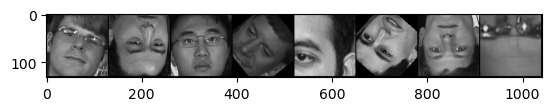

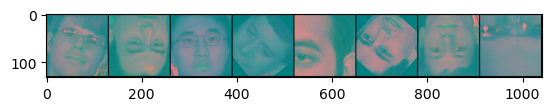

In [7]:
# show some images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

## Function for concating L and AB channels

In [8]:
def cat_l_ab(images_gray, images_ab):
    return torch.cat((images_gray, images_ab), 1)

## Define network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 2, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 2, 2, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        midlevel = self.downsample(x)
        output = self.upsample(midlevel)
        return output

net = Net()

### Move to cuda if possible

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


## Define optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0.0)

## Train

In [12]:
epoch_history = {'1': []}
num_mini_batch_print = 50

def train_step(engine, batch):
    # get the inputs; data is a list of [inputs, labels]
    images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(images_gray)
    loss = criterion(outputs, images_ab)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

def validation_step(engine, batch):
    with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        # forward
        outputs = net(images_gray)
        #outputs = cat_l_ab(images_gray, outputs)

        #return outputs, images_color
        return outputs, images_ab

evaluator = Engine(validation_step)
metric = Loss(criterion)
metric.attach(evaluator, 'mse')

@trainer.on(Events.ITERATION_COMPLETED(every=num_mini_batch_print))
def log_training_loss(trainer):
    # Record loss
    global epoch_history
    epoch_history[f'{trainer.state.epoch}'].append(trainer.state.output)
    
    # Print progress every so often
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.5f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch + 1 }'] = []
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(valloader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
evaluator.add_event_handler(Events.COMPLETED, handler)

trainer.run(trainloader, max_epochs=20)

Epoch[1] Loss: 0.00063
Epoch[1] Loss: 0.00043
Epoch[1] Loss: 0.00042
Epoch[1] Loss: 0.00038
Epoch[1] Loss: 0.00037
Epoch[1] Loss: 0.00030
Epoch[1] Loss: 0.00027
Epoch[1] Loss: 0.00030
Epoch[1] Loss: 0.00030
Epoch[1] Loss: 0.00043
Epoch[1] Loss: 0.00050
Epoch[1] Loss: 0.00067
Epoch[1] Loss: 0.00031
Epoch[1] Loss: 0.00039
Epoch[1] Loss: 0.00032
Epoch[1] Loss: 0.00036
Training Results - Epoch: 1  Avg loss: 0.00038
Validation Results - Epoch: 1  Avg loss: 0.00043
Epoch[2] Loss: 0.00055
Epoch[2] Loss: 0.00033
Epoch[2] Loss: 0.00031
Epoch[2] Loss: 0.00041
Epoch[2] Loss: 0.00045
Epoch[2] Loss: 0.00035
Epoch[2] Loss: 0.00031
Epoch[2] Loss: 0.00032
Epoch[2] Loss: 0.00036
Epoch[2] Loss: 0.00044
Epoch[2] Loss: 0.00033
Epoch[2] Loss: 0.00030
Epoch[2] Loss: 0.00020
Epoch[2] Loss: 0.00034
Epoch[2] Loss: 0.00027
Epoch[2] Loss: 0.00031
Epoch[2] Loss: 0.00042
Training Results - Epoch: 2  Avg loss: 0.00036
Validation Results - Epoch: 2  Avg loss: 0.00041
Epoch[3] Loss: 0.00023
Epoch[3] Loss: 0.00029
Epo

2021-10-25 14:54:44,137 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch: 6  Avg loss: 0.00034
Validation Results - Epoch: 6  Avg loss: 0.00039


State:
	iteration: 5064
	epoch: 6
	epoch_length: 844
	max_epochs: 20
	output: 0.0002101942664012313
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Plot results of each epoch vs loss

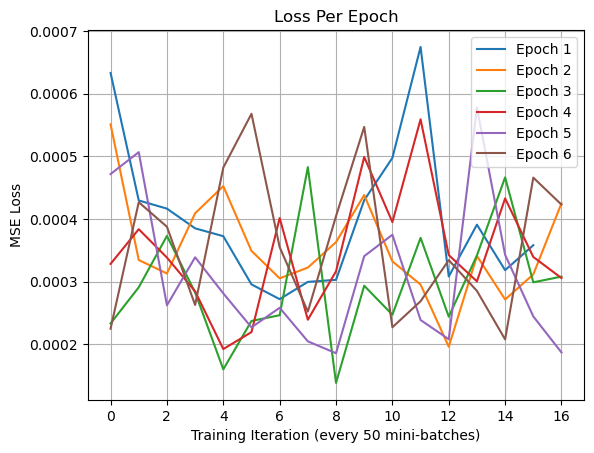

In [13]:
plt.clf()

for i in range(1, len(epoch_history)):
    plt.plot(range(len(epoch_history[f'{i}'])), epoch_history[f'{i}'], label=f'Epoch {i}')

plt.legend(loc="upper right")
plt.xlabel(f'Training Iteration (every {num_mini_batch_print} mini-batches)')
plt.ylabel('MSE Loss')
plt.title('Loss Per Epoch')
plt.grid(True)
plt.savefig('epoch_loss_chart.png')
plt.show()

## Save Model

In [14]:
PATH = './colorize_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model
### Peak at 4 test examples

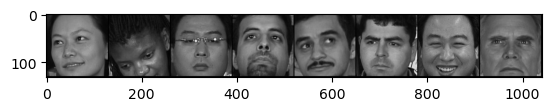

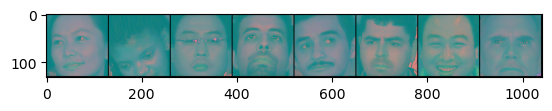

In [15]:
dataiter = iter(testloader)
images_gray, images_color, images_ab = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_gray), 'input_gray.png')
imshow(torchvision.utils.make_grid(images_color), 'input_lab.png')

### Look at model performance on these examples

In [16]:
outputs = net(images_gray.to(device)).cpu()

### Combine l, a and b channels

In [17]:
outputs_color = cat_l_ab(images_gray, outputs)

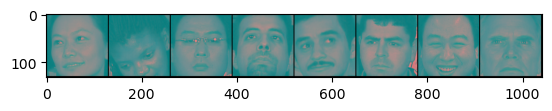

In [18]:
imshow(torchvision.utils.make_grid(outputs_color), 'output_lab.png')

## Convert Tensor output to RGB

In [19]:
def tensor_to_rgb(tensors):
    images_RGB = []

    for tensor in tensors:
        color_image = tensor.detach().clone().numpy()
        color_image = np.transpose(color_image, (1,2,0))
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
        color_image = lab2rgb(color_image.astype(np.float64))
        color_image = np.transpose(color_image, (2,0,1))
        images_RGB.append(color_image)

    return torch.tensor(np.array(images_RGB))

Input:


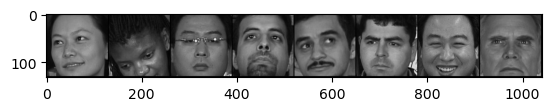

Ground truth:


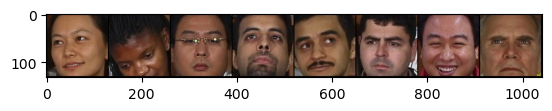

Colorize Net outputs:


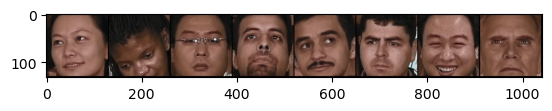

MSE loss for each image:

0.00074	0.00024	0.00017	0.00028	0.00043	0.00017	0.00043	0.00033


In [20]:
print('Input:')
imshow(torchvision.utils.make_grid(images_gray))
print('Ground truth:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(images_color)), 'input_color.png')
print('Colorize Net outputs:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(outputs_color)), 'output_color.png')

# Also show MSE loss for each image
test_batch_losses = []

for i, output in enumerate(outputs):
    test_batch_losses.append(f'{criterion(output, images_ab[i]).tolist():.5f}')

print("MSE loss for each image:\n")
print(*test_batch_losses, sep = "\t") 

## Evaluate performance on whole test set

In [21]:
# Create empty output directory
output_dir = './Output'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir)

In [22]:
test_loss = []

with torch.no_grad():
    for i, data in enumerate(testloader):
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)

        # forward + backward + optimize
        outputs = net(images_gray)
        outputs_lab = torch.cat((images_gray, outputs), 1)
        
        rgb_outputs = tensor_to_rgb(outputs_color.cpu())
        
        for j in range(outputs.shape[0]):
            loss = criterion(outputs[j], images_ab[j])
            test_loss.append(loss)
            
            # Save images
            img_idx = (i * batch_size) + j
            img_path = os.path.join(output_dir, transformed_test_dataset.image_paths[img_idx])
            img_data = torch.permute(rgb_outputs[j], (1, 2, 0)).numpy()
            io.imsave(img_path, img_data)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [23]:
print(f'Average test loss: {torch.mean(torch.tensor(test_loss))}')

Average test loss: 0.0003825637395493686
